In [1]:
# for google colaboratory
from os import path
if 'google.colab' in str(get_ipython()):
    files = ['LLD-icon-names.pkl', 'LLD-icon_PKL.zip', 'LLD-icon-sharp.hdf5', 
             'LLD-icon-sharp_indices.pkl']
    !pip install wget
    import wget
    import shutil
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir Data
    for f in files:
        if not path.isfile('Data/' + f):
            if path.isfile('/content/drive/My Drive/Colab/AFRO/' + f):
                shutil.copy('/content/drive/My Drive/Colab/AFRO/' + f, 'Data')
            else:
                wget.download('https://data.vision.ee.ethz.ch/sagea/lld/data/' + f, 'Data')
    !unzip -q -n Data/LLD-icon_PKL.zip -d Data

In [2]:
# for debugging ------
from importlib import reload
# -------------------
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In c:\users\svetl\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\svetl\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\svetl\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\users\svetl\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

# Open data

## icon-sharp

In [3]:
files = h5py.File('Data/LLD-icon-sharp.hdf5', 'r')

In [4]:
files.keys()

<KeysViewHDF5 ['data', 'labels', 'meta_data']>

In [5]:
clusters = files['labels/resnet/rc_128']
names = files['meta_data/names']
images = files['data']

### show clasters

In [ ]:
unique = len(set(clusters[()]))
samples = 8
fig, axs = plt.subplots(unique, samples, figsize=(10, 50))
for i in range(unique):
        indices = np.argwhere(clusters[()]==i)
        for j in range(8):
                axs[i,j].imshow(np.moveaxis(images[indices[j]], 1, -1).squeeze(0))
                axs[i,j].axis('off')

## icon_data

In [ ]:
with open('Data/LLD-icon/LLD-icon_data_0.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [ ]:
data.shape

In [ ]:
plt.imshow(data[1])

In [ ]:
with open('Data/LLD-icon-names.pkl', 'rb') as f:
    labels = pickle.load(f)

In [ ]:
len(labels)

# Create text and add to icon

In [32]:
import albumentations as A
import cv2 as cv
# custom module --- 
import utils
utils = reload(utils)
from utils import text_to_pic_transform, join_images
# ------------------

In [33]:
from skimage.transform import resize
size = (128, 128)
img = resize(np.moveaxis(images[0], 0, -1), size, mode='constant', anti_aliasing=True,)


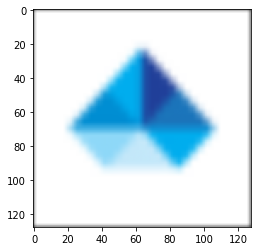

In [34]:
plt.imshow(img)

In [35]:
text_img = text_to_pic_transform('Hello')


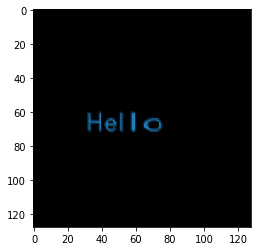

In [36]:
plt.imshow(text_img)

In [37]:
plt.imshow(join_images(img, text_img))

error: OpenCV(4.4.0) c:\users\appveyor\appdata\local\temp\1\pip-req-build-52oirelq\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x5de50a1e::Set<1,-1,-1>,struct cv::impl::A0x5de50a1e::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


# Подготовка данных

In [ ]:
import models
models = reload(models)
from models import Generator, Discriminator, WGAN

import tensorflow.keras as keras
import tensorflow as tf

In [ ]:
plt.imshow(dst)

files = h5py.File('Data/LLD-icon-sharp.hdf5', 'r')
images = files['data']

batch_size = 64
images = np.array(images)
images = np.moveaxis(images, 1, -1)
images = images.astype("float32") / 255.0
dataset = tf.data.Dataset.from_tensor_slices(images)

# Создание и тренировка модели

In [ ]:
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)


In [ ]:
gen = Generator(100, 3)
disc = Discriminator((32, 32, 3))

In [ ]:
gan = WGAN(discriminator=disc, generator=gen, latent_dim=100)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [ ]:
gan.fit(dataset.take(100), epochs=1)